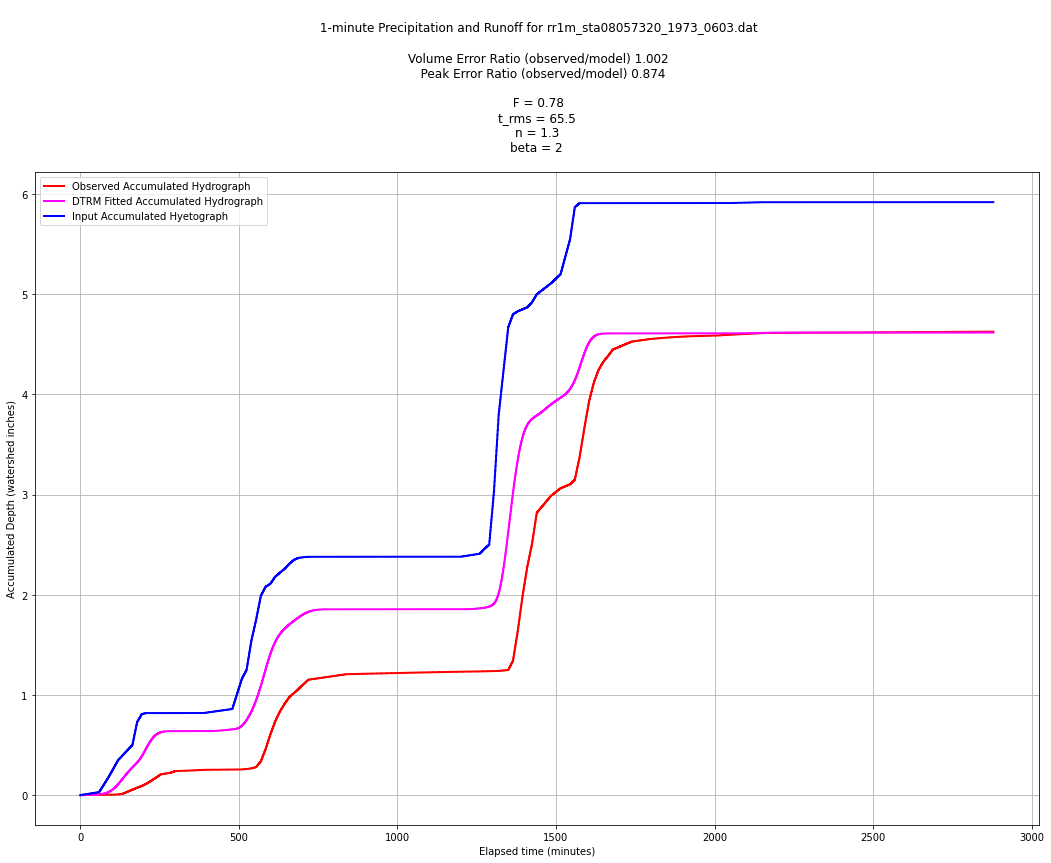

In [25]:
# Script reads RARO files and plots hydrographs
# Data from DTRM analysis
F = 0.78 # Use F value from DTRM model
CN = 93.25 # Use value from GIS
scale = 2 # a scale constant - has units of rate
shape = 1.3 # Use N value from DTRM analysis spreadsheet
tbar = 65.5 # Use t_rms value from DTRM analysis spreadsheet
beta = 2 # Use beta value (1 or 2) from DTRM analysis spreadsheet
filename = 'rr1m_sta08057320_1973_0603.dat' # filename to read

def prMat(amatrix):
    # prints the contents of amatrix to stdio
    howMany = len(amatrix) # get row count
    lowWide = len(amatrix[0]) # get column count
    for irow in range(howMany):
        print(amatrix[irow])
    return()

# plotting functions from CE 5361
import matplotlib.pyplot as plt  

def Plot2Lines(list1,list2,list3,list4,ptitle,xlabel,ylabel,legend1,legend2):
# Create a line chart of list2,list4 on y axis and list1,list3 on x axis
    mydata = plt.figure(figsize = (18,6)) # build a drawing canvass from figure class; aspect ratio 4x3
    plt.plot(list1, list2, c='red', marker='.',linewidth=2) # basic line plot
    plt.plot(list3, list4, c='blue', marker='.',linewidth=1) # basic line plot
    plt.xlabel(xlabel) # label the x-axis
    plt.ylabel(ylabel) # label the y-axis, notice the LaTex markup
    plt.legend([legend1,legend2]) # legend for each series
    plt.title(ptitle) # make a plot title
#    plt.xlim(100000, 120000)
#    plt.ylim(2700, 2850)
    plt.grid() # display a grid
    plt.show() # display the plot
    return()

def Plot2Stairs(list1,list2,list3,list4,ptitle,xlabel,ylabel,legend1,legend2):
# Create a line chart of list2,list4 on y axis and list1,list3 on x axis
    mydata = plt.figure(figsize = (18,6)) # build a drawing canvass from figure class; aspect ratio 4x3
    plt.step(list1, list2, c='red', marker='.',linewidth=2) # basic line plot
    plt.step(list3, list4, c='blue', marker='.',linewidth=1) # basic line plot
    plt.xlabel(xlabel) # label the x-axis
    plt.ylabel(ylabel) # label the y-axis, notice the LaTex markup
    plt.legend([legend1,legend2]) # legend for each series
    plt.title(ptitle) # make a plot title
#    plt.xlim(100000, 120000)
#    plt.ylim(2700, 2850)
    plt.grid() # display a grid
    plt.show() # display the plot
    return()

def Plot3Stairs(list1,list2,list3,list4,list5,list6,ptitle,xlabel,ylabel,legend1,legend2,legend3,savefile):
# Create a line chart of list2,list4 on y axis and list1,list3 on x axis
    mydata = plt.figure(figsize = (18,12)) # build a drawing canvass from figure class; aspect ratio 4x3
    plt.step(list1, list2, c='red', marker='',linewidth=2) # basic line plot
    plt.step(list3, list4, c='magenta', marker='',linewidth=2) # basic line plot
    plt.step(list5, list6, c='blue', marker='',linewidth=2) # basic line plot
    plt.xlabel(xlabel) # label the x-axis
    plt.ylabel(ylabel) # label the y-axis, notice the LaTex markup
    plt.legend([legend1,legend2,legend3]) # legend for each series
    plt.title(ptitle) # make a plot title
#    plt.xlim(100000, 120000)
#    plt.ylim(2700, 2850)
    plt.grid() # display a grid
    plt.savefig(savefile,bbox_inches='tight',pad_inches=0.5) # save to a file for documents
    plt.show() # display the plot
    return()

################################
#   connect and read file      #
################################

#filename = 'rr1m_sta08048530_1970_0425.dat' # filename to read
afile = open(filename,"r")  # connect and read file 
amatrix = [] # null object to store read
rowNumA = 0
for line in afile:
# if line contains comment statement then skip
    if line[0]=="#":
#        print('comment line')
        continue
    else:
        amatrix.append([float(n) for n in line.strip().split()])
        rowNumA += 1
afile.close() # Disconnect the file
#print(rowNumA) # for debugging activate
#prMat(amatrix) # for debugging activate

################################
#   build lists for plotting   #
################################

time = []
acc_rain = []
acc_flow = []
for irow in range(rowNumA):
    time.append(amatrix[irow][0])
    acc_rain.append(amatrix[irow][1])
    acc_flow.append(amatrix[irow][2])

title = "1-minute Precipitation and Runoff for " + filename
xlabel = "Elapsed time (minutes)"
ylabel = "Accumulated Depth (watershed inches)"
legend1 = "Accumulated Runoff"
legend2 = "Accumulated Precipitation"
#Plot2Lines(time,acc_flow,time,acc_rain,title,xlabel,ylabel,legend1,legend2);

# cumulative/incremental functions (old R code)



# cumulative to incremental
def disaggregate(x,y):
    ''' 
    x and y are equal length lists
    
    returns a new list containing the incremental changes along x-axis
    '''
    if len(x) != len(y):
        raise ValueError("lists are different length in disaggregate")
    n=len(x) # length of vectors
    dfdx=[0 for i in range(n)]; # dfdx starts as list of zeros
    for i in range(1,n):
        dfdx[i] = (y[i] - y[i-1])/(x[i]- x[i-1])  
    return dfdx

# incremental to cumulative
def aggregate(vector1,vector2):
    n=len(vector1)
    # fill vector2 with zeros
    vector2 = [0 for i in range(n)]
    vector2[0] = vector1[0]+0.0
    for i in range(1,n):
        vector2[i] = vector2[i-1] + vector1[i]
    return vector2

################################
#  Leinhard Hydrograph Kernel  #
################################
def kernelfn(tbar,time,scale=2,shape=3,beta=2):
    ''' 
        kernel function for a unit hydrograph - uses a gamma-type hydrograph

          scale: a scaling parameter, should be 2, but left adjustable for grins
          shape: Nash's reservoir number
           tbar: Characteristic time, lag time in NRCS, time-to-peak, 
                 and time-of-concentration are all similar concepts.
           beta: Exponent controling decay rate in exponential part of function; 
                 Should be a 2 or 3 for typical watersheds, but left adjusible for 
                 ornery cases.
    '''
    import math
    term1 = (scale/tbar)/math.gamma(shape)
    term2 = (time)/tbar
    term3 = term2**(2*shape-1)
    term4 = math.exp(-1*term2**beta)
    kernelfn = term1*term3*term4
    return kernelfn
#####################################
# CN loss model on cumulative lists #
#####################################
def xsrain(cumP,CN):
    S = (1000/CN)-10.0
    Ia = 0.2*S
    if cumP >= Ia:
        xsrain=S*(cumP-Ia)/(cumP-Ia+S)
    else:
        xsrain=0.0
    return xsrain  
##################
# Apply CN model #
##################
#CN = 75
excess_p = [0 for i in range(len(acc_rain))]
for i in range(len(acc_rain)):
    excess_p[i] = xsrain(acc_rain[i],CN) # p_model should be in cumulative space
# Convert into rates for unitgraph analysis
#excess_r = []
#excess_r = disaggregate(t_model,excess_p)
# compute incremental values
incremental_rain = disaggregate(time,acc_rain)
incremental_flow = disaggregate(time,acc_flow)
incremental_xs   = disaggregate(time,excess_p)

# Debugging Section
# plot the data
#Plot2Stairs(time,incremental_flow,time,incremental_rain,title,xlabel,ylabel,legend1,legend2);


# now build Leinhard model(s)
#F = 0.3021 # Use F value from DTRM model   Activate for proportional loss model
# Excess rain
#xs_rain = [0 for i in range(len(incremental_rain))]
#for irow in range(len(incremental_rain)):
#    xs_rain[irow]=incremental_rain[irow]*F
    
# now build Leinhard model(s)
#F = 1.0  # 
# Excess rain
xs_rain = [0 for i in range(len(incremental_xs))]
for irow in range(len(incremental_xs)):
#    xs_rain[irow]=incremental_xs[irow] # use this for CN model
    xs_rain[irow]=incremental_rain[irow]*F # use this for F model
    
# Debugging Section
#Plot2Stairs(time,incremental_flow,time,xs_rain,title,xlabel,ylabel,legend1,legend2);
#print("Total Runoff : ",sum(incremental_flow))
#print("Total Excess : ",sum(xs_rain))


# discrete convolution function
def convolve(duration, excitation, kernel):
    response = [0 for i in range(duration)] # populate response vector with zeros
  # response = direct runoff hydrograph (unscaled)
  # excitation = input rate in length per time
  # kernel = unit response
    for i in range(duration):
        for j in range(i,duration-1):
            response[j]=excitation[i]*kernel[(j-i)+1]+response[j]
    return(response)
#def convolve(N1,excitation,kernel):
# N1 is length of kernel list (already populated)
# excitation is list of inputs (aka rainfall)
# kernel is list of unit responses
# response is convolved response
 #   response = [0.0 for i in range(N1)] # populate response vector with zeros
  #  for i in range(1,N1):
   #     for j in range(i,N1):
    #        response[j] = excitation[i]*kernel[(j-i)]+response[j]
   # return response

# now build the runoff hydrograph
N1 = len(xs_rain)
kernel = []
### parameters from DTRM analysis
#scale = 2 # a scale constant - has units of rate
#shape = 2.435991875 # Use N value from DTRM analysis spreadsheet
#tbar = 23.41494069 # Use t_rms value from DTRM analysis spreadsheet
#beta = 2 # Use beta value (1 or 2) from DTRM analysis spreadsheet
# the actual UH kernel
for i in range(N1):
    kernel.append(kernelfn(0.6*tbar,time[i],scale,shape,beta))
# the convolution
response = convolve(N1,xs_rain,kernel)

#####################################
# Plot Results for Particular Storm #
#####################################

# Incremental Representation
legend1 = 'Observed Hydrograph'
legend2 = 'DTRM Fitted Hydrograph'
ptitle = "Fitted Hydrograph" + \
"\n Volume Error Ratio (observed/model) " \
+ repr(round(sum(incremental_flow)/sum(response),3))\
+ "\n   Peak Error Ratio (observed/model) " \
+ repr(round(max(incremental_flow)/max(response),3)) \
+ "\n Kernel Integral : " + repr(round(sum(kernel)))
ylabel = 'Incremental Rate (inches/minute)'
#Plot2Stairs(time,incremental_flow,time,response,ptitle,xlabel,ylabel,legend1,legend2);

# Cumulative Representation
legend2 = 'DTRM Fitted Accumulated Hydrograph'
legend1 = 'Observed Accumulated Hydrograph'
ptitle = "\n 1-minute Precipitation and Runoff for " + filename + "\n"\
"\n Volume Error Ratio (observed/model) " \
+ repr(round(sum(incremental_flow)/sum(response),3))\
+ "\n   Peak Error Ratio (observed/model) " \
+ repr(round(max(incremental_flow)/max(response),3)) \
+ "\n\n F = " + repr(round(F,4)) + "\n"\
+ "t_rms = " + repr(round(tbar,4)) + "\n"\
+ "n = " + repr(round(shape,4)) + "\n"\
+ "beta = " + repr(round(beta,4)) + "\n"
ylabel = "Accumulated Depth (watershed inches)"
accResponse = [0 for i in range(len(response))]
accResponse = aggregate(response,accResponse)
#Plot2Stairs(time,incremental_rain,time,incremental_xs,ptitle,xlabel,ylabel,legend1,legend2);

# Debugging
legend1 = 'Observed Accumulated Hydrograph'
legend2 = 'DTRM Fitted Accumulated Hydrograph'
legend3 = 'Input Accumulated Hyetograph'
ylabel = "Accumulated Depth (watershed inches)"
savefile = filename + ".cum.png"
Plot3Stairs(time,acc_flow,time,accResponse,time,acc_rain,ptitle,xlabel,ylabel,legend1,legend2,legend3,savefile);

# Incremental Representation
legend1 = 'Observed Incremental Hydrograph'
legend2 = 'DTRM Fitted Incremental Hydrograph'
legend3 = 'Input Hyetograph'
ylabel = 'Incremental Rate (inches/minute)'
savefile = filename + ".inc.png"
#Plot3Stairs(time,incremental_flow,time,response,time,incremental_rain,ptitle,xlabel,ylabel,legend1,legend2,legend3,savefile);